In [1]:
import numpy as np

In [18]:
def remove_bad_chs(channel_groups, bad_ch_list):
    for k, v in channel_groups.items():
        for ch in v['channels']:
            if ch in bad_ch_list:
                idx = v['channels'].index(ch)
                v['channels'].pop(idx)
                v['geometry'].pop(ch)
    return channel_groups

def convert_sites_to_channels(site_groups, acq_channels_numbers, acq_site_mapping):
    """
    This maps sites to channels for geometries and the site lists. Also checks for integrity of site lists.
    
    site_groups is a dictionary with sites and geometries keys.
    acq_channel_numbers is a list of channels in order from the acquistion system (ie a range from 0-63).
    acq_site_mapping is a list of site numbers corresponding to the acquisition channel numbers specified above.
    
    
    So this will map:
        site_groups {
            0: {
            'sites': [46,45,44]
            }
        }
        acq_channel_numbers = [1,2,3]
        acq_site_mapping = [45, 46, 46]
        
        to:
        site_groups {
            0: {
            'sites': [3, 2, 1]
            }
        }
    """
    all_ch = []
    for k, v in site_groups.items():
        all_ch.extend(v['sites'])
    print ("{0} sites found on all groups.".format(len(all_ch)))
    bad = False
    for i in all_ch:
        nmatches = 0
        for ii in all_ch:
            if ii == i:
                nmatches += 1
        if nmatches >= 2:
            print ("ERROR: duplicate site of number {0} found.".format(i))
            bad = True
    if bad:
        return None
    else:
        print ("No duplicate channels.")
        
    for k, v in site_groups.items():
        site_list = v['sites']
        geo = v['geometry'].keys()
        
        assert len(site_list) == len(geo)
        
        for s in site_list:
            if s not in geo:
                raise ValueError('Site {0} specified in "sites" but not in "geometry" for shank {1}'.format(s, k))
        for s in geo:
            if s not in site_list:
                raise ValueError('Site {0} specified in "geometry" but not "sites" for shank {1}'.format(s, k))        
    print('Site and geometry lists are congruent.')
    
    channel_groups = {}
    for g, v in site_groups.items():
        channel_group = {}
        channels = []
        geometry = {}
        for s in v['sites']:
            site_idx = acq_site_mapping.index(s)
            ch = acq_channels_numbers[site_idx]
            channels.append(ch)
        channel_group['channels'] = channels
        
        for s, v in v['geometry'].items():
            site_idx = acq_site_mapping.index(s)
            ch = acq_channels_numbers[site_idx]
            geometry[ch] = v
        channel_group['geometry'] = geometry
        
        channel_groups[g] = channel_group
    return channel_groups

def linear_shank_graph(channel_list):
    """
    makes a graph to connect sites on a linear probe (ie Buszaki 64)
    """
    graph = []
    for i in range(len(channel_list)):
        a1 = channel_list[i]
        for ii in range(1, 3):
            try:
                a2 = channel_list[i+ii]
                graph.append((a1, a2))
            except:
                pass
    return graph

def make_graphs(channel_groups):
    for k in  channel_groups.keys():
        group = channel_groups[k]
        channels = group['channels']
        group['graph'] = linear_shank_graph(channels)
    return channel_groups

In [20]:
SGL_64 = {
    'raw_channels': range(64),
    'HIRES_4x16_flipchip': [
        18, 20, 21, 23, 24, 25, 26, 27, 31, 30, 29, 32, 28, 22, 19, 17, 48, 46, 43, 37, 33, 36, 35, 34, 38, 39, 40, 41,
        42, 44, 45, 47, 1, 3, 6, 8, 10, 12, 14, 16, 15, 13, 11, 9, 7, 5, 4, 2, 63, 61, 60, 58, 56, 54, 52, 50, 49, 51,
        53, 55, 57, 59, 62, 64
    ],
    'NanoZ': [
        34, 36, 38, 40, 42, 44, 46, 48, 47, 45, 43, 41, 39, 37, 35, 33, 57, 59, 62, 64, 50, 52, 54, 56, 55, 53,
        51, 49, 63, 61, 60, 58, 1, 3, 5, 7, 9, 11, 13, 15, 16, 14, 12, 10, 8, 6, 4, 2, 26, 28, 29, 31, 17, 19, 21,
        23, 24, 22, 20, 18, 32, 30, 27, 25
    ],
}

In [13]:
geometries = ((0, 0), (-8, 20), (8, 40), (-12, 60), (12, 80), (-16, 100), (16, 120), (-20, 140), 
              (20, 160), (-24, 180), (24, 200), (-30, 220), (30, 240), (-34, 260), (34, 280), (-40, 300))

site_groups = {
    0: {
        'sites': [56, 57, 55, 58, 54, 59, 53, 60, 52, 61, 51, 62, 50, 63, 49, 64]
    },
    1: {
        'sites': [41, 37, 33, 42, 40, 43, 36, 44, 39, 45, 35, 46, 38, 47, 34, 48]
    },
    2: {
        'sites': [28, 24, 23, 32, 22, 25, 21, 29, 20, 26, 19, 30, 18, 27, 17, 31]
    },
    3: {
        'sites': [8, 9, 7, 10, 6, 11, 5, 12, 4, 13, 3, 14, 2, 15, 1, 16]
    }
}

In [14]:
for gnum, group in site_groups.items():
    group['geometry'] = {}
    sites = group['sites']
    assert len(group['sites']) == len(geometries)
    for i in range(len(sites)):
        sitenum = sites[i]
        pos = geometries[i]
        group['geometry'][sitenum] = (pos[0] + 200*gnum, pos[1])

In [15]:
site_groups

{0: {'geometry': {49: (34, 280),
   50: (30, 240),
   51: (24, 200),
   52: (20, 160),
   53: (16, 120),
   54: (12, 80),
   55: (8, 40),
   56: (0, 0),
   57: (-8, 20),
   58: (-12, 60),
   59: (-16, 100),
   60: (-20, 140),
   61: (-24, 180),
   62: (-30, 220),
   63: (-34, 260),
   64: (-40, 300)},
  'sites': [56, 57, 55, 58, 54, 59, 53, 60, 52, 61, 51, 62, 50, 63, 49, 64]},
 1: {'geometry': {33: (208, 40),
   34: (234, 280),
   35: (224, 200),
   36: (216, 120),
   37: (192, 20),
   38: (230, 240),
   39: (220, 160),
   40: (212, 80),
   41: (200, 0),
   42: (188, 60),
   43: (184, 100),
   44: (180, 140),
   45: (176, 180),
   46: (170, 220),
   47: (166, 260),
   48: (160, 300)},
  'sites': [41, 37, 33, 42, 40, 43, 36, 44, 39, 45, 35, 46, 38, 47, 34, 48]},
 2: {'geometry': {17: (434, 280),
   18: (430, 240),
   19: (424, 200),
   20: (420, 160),
   21: (416, 120),
   22: (412, 80),
   23: (408, 40),
   24: (392, 20),
   25: (384, 100),
   26: (376, 180),
   27: (366, 260),
   28:

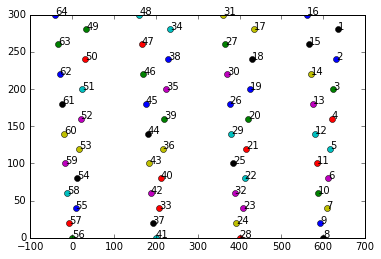

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
for g in site_groups.values():
    for num, pos in g['geometry'].items():
        plt.plot(pos[0], pos[1], 'o')
        plt.text(pos[0], pos[1], num)

In [21]:
channel_groups = convert_sites_to_channels(site_groups, SGL_64['raw_channels'], SGL_64['HIRES_4x16_flipchip'])

64 sites found on all groups.
No duplicate channels.
Site and geometry lists are congruent.


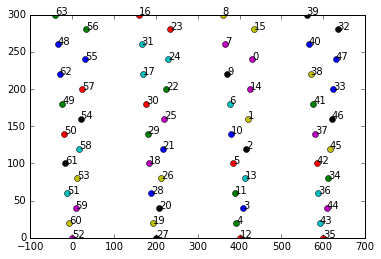

In [22]:
for g in channel_groups.values():
    for num, pos in g['geometry'].items():
        plt.plot(pos[0], pos[1], 'o')
        plt.text(pos[0], pos[1], num)

In [23]:
NZ_bad = []
def nz_to_sgl(nz_chs, acq_ch_map, nz_ch_map):
    ac_chs = []
    for ch in nz_chs:
        idx = nz_ch_map.index(ch)
        ac_chs.append(acq_ch_map[idx])
        ac_chs.sort()
    return ac_chs

a= nz_to_sgl(NZ_bad, SGL_64['raw_channels'], SGL_64['NanoZ'])
print (a)
print ([x+64 for x in a])

[]
[]


In [24]:
channel_groups = remove_bad_chs(channel_groups, [])

In [25]:
channel_groups = make_graphs(channel_groups)

In [26]:
channel_groups

{0: {'channels': [52,
   60,
   59,
   51,
   53,
   61,
   58,
   50,
   54,
   49,
   57,
   62,
   55,
   48,
   56,
   63],
  'geometry': {48: (-34, 260),
   49: (-24, 180),
   50: (-20, 140),
   51: (-12, 60),
   52: (0, 0),
   53: (12, 80),
   54: (20, 160),
   55: (30, 240),
   56: (34, 280),
   57: (24, 200),
   58: (16, 120),
   59: (8, 40),
   60: (-8, 20),
   61: (-16, 100),
   62: (-30, 220),
   63: (-40, 300)},
  'graph': [(52, 60),
   (52, 59),
   (60, 59),
   (60, 51),
   (59, 51),
   (59, 53),
   (51, 53),
   (51, 61),
   (53, 61),
   (53, 58),
   (61, 58),
   (61, 50),
   (58, 50),
   (58, 54),
   (50, 54),
   (50, 49),
   (54, 49),
   (54, 57),
   (49, 57),
   (49, 62),
   (57, 62),
   (57, 55),
   (62, 55),
   (62, 48),
   (55, 48),
   (55, 56),
   (48, 56),
   (48, 63),
   (56, 63)]},
 1: {'channels': [27,
   19,
   20,
   28,
   26,
   18,
   21,
   29,
   25,
   30,
   22,
   17,
   24,
   31,
   23,
   16],
  'geometry': {16: (160, 300),
   17: (170, 220),
   18:

In [27]:
try:
    from pprint import pformat
except ImportError:
    pformat = print
f = open('/home/cdw291/probes/HIRES_j10_2_spyking.prb', 'w')
f.write("channel_groups = {0}\n".format(pformat(channel_groups)))
f.close()

DOUBLE DOWN
---
Make a probe file for double 64 ch probes

In [13]:
# dual_ch_groups = {}
# group_shifts = (0,4)
# ch_shifts = (0, 64)

# for gshift, cshift in zip(group_shifts, ch_shifts):
#     for k, v in channel_groups.items():
#         channels = [x + cshift for x in v['channels']]
#         geometry = {}
#         for kk, vv in v['geometry'].items():
#             geometry[kk + cshift] = vv
#         graph = []
#         for i in v['graph']:
#             graph.append([x+cshift for x in i])
#         dual_ch_groups[k+gshift] = {
#             'channels': channels,
#             'geometry': geometry,
#             'graph': graph
#         }


In [15]:
cgroupsdual = {}
for k, v in channel_groups.items():
    cgroupsdual[k] = v
    gnum = k+4
    cgroupsdual[gnum] = {'geometry': {}}
    
    cgroupsdual[gnum]['channels'] = [x+64 for x in v['channels']]
    for s, g in v['geometry'].items():
        cgroupsdual[gnum]['geometry'][s+64] = (g[0]+ 800, g[1])
    cgroupsdual[gnum]['graph'] = []

In [16]:
f = open('/home/cdw291/probes/whisper/HIRES_dual_spyking.prb', 'w')
# pickle.dump(channel_groups, f, 0)
f.write("channel_groups = {0}\n".format(pformat(cgroupsdual)))
f.close()

In [ ]:
from pprint import pprint

In [ ]:
pprint (cgroupsdual)

In [ ]:
a = {'a' : {'b': 84}}

In [ ]:
b = {}
b['a'] = a['a']

In [ ]:
b['a']['b'] += 1

In [ ]:
a